In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import easydict 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import samplers
from google.colab import files

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dimension):
      
        super(Discriminator, self).__init__()
        
        self.input_dimension = input_dimension
        
        self.activation = nn.ReLU()
        
        self.input_layer = nn.Sequential(
            nn.Linear(self.input_dimension, 1024),
            self.activation
        )
        
        self.hidden_layer = nn.Sequential(
            nn.Linear(1024, 1024),
            self.activation
        )

        self.output_layer = nn.Sequential(
            nn.Linear(1024, 1)
        )

    def forward(self, x):
      
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        
        return x

In [0]:
def JensenShannon_Train(p, q, input_dim):
  
  D = Discriminator(input_dim).cuda()
  #optimizer = torch.optim.Adam(D.parameters(), lr= 1e-3)
  optimizer = SGD(D.parameters(), lr= 1e-3)
  
  for iter_ in range(10000):
    
        optimizer.zero_grad()
        x = torch.from_numpy(next(p)).float().cuda()
        y = torch.from_numpy(next(q)).float().cuda()
        
        Ex = torch.mean(torch.log(torch.sigmoid(D(x))))
        Ey = torch.mean(torch.log(1 - torch.sigmoid(D(y))))
        
        loss = -Ex - Ey
        loss.backward()
        optimizer.step()
        
        if iter_ % 100 == 0 or (iter_ < 100 and iter_ % 10 == 0):
          print("\tEpoch ", iter_, "JS_loss = ", loss.data.cpu().numpy())

  return D

In [0]:
def Wasserstein_Train(p, q, input_dim):
  
  D = Discriminator(input_dim).cuda()
  #optimizer = torch.optim.Adam(D.parameters(), lr= 1e-3)
  optimizer = SGD(D.parameters(), lr= 1e-3)
  
  # Uniform distribution U[0, 1]
  a_dist = samplers.distribution2(batch_size=512)
  Lambda = 10
 
  for iter_ in range(10000):
    
        optimizer.zero_grad()
        x = torch.from_numpy(next(p)).float().cuda()
        y = torch.from_numpy(next(q)).float().cuda()
        
        Ex = D(x).mean()
        Ey = D(y).mean()
        
        a = torch.from_numpy(next(a_dist)).float().cuda()
            
        z = a*x + (1 - a)*y
        z.requires_grad_(True)
        
        
        gradient = torch.autograd.grad(D(z), z, grad_outputs=torch.ones(D(z).size()).cuda(), create_graph=True)[0]
        norm_gradient = torch.norm(gradient, p=2, dim=1)
        penalty = (norm_gradient - 1).pow(2).mean()
        
        loss = -((Ex - Ey) - Lambda*penalty)
        loss.backward()
        optimizer.step()
        
        if iter_ % 100 == 0 or (iter_ < 100 and iter_ % 10 == 0):
          print("\tEpoch ", iter_, "WD_loss = ", loss.data.cpu().numpy())

  return D

In [0]:
def JensenShannon_Distance_Estimator(p, q, D):
  
    x = torch.from_numpy(next(p)).float().cuda()
    y = torch.from_numpy(next(q)).float().cuda()
    
    Ex = torch.mean(torch.log(torch.sigmoid(D(x))))
    Ey = torch.mean(torch.log(1 - torch.sigmoid(D(y))))

    fo = np.log(2) + ((0.5*Ex) + (0.5*Ey)).data.cpu().numpy()
    
    return fo

In [0]:
def Wasserstein_Distance_Estimator(p, q, D):
  
    x = torch.from_numpy(next(p)).float().cuda()
    y = torch.from_numpy(next(q)).float().cuda()
    
    Ex = torch.mean(D(x))
    Ey = torch.mean(D(y))
    
    fo = (Ex - Ey).data.cpu().numpy()
    
    return fo

In [0]:
def question3():
    
    #Data points to be plotted
    X_theta = []
    Y_estimate_wd = []
    Y_estimate_js = []
    
    input_dim = 2
    theta_list = np.round_(np.linspace(-1, 1, 21, endpoint=True), decimals=1)
    
    #p is uniform distribution [0,Z]
    p = samplers.distribution1(0, batch_size=512)

    #theta [-1,1] with interval of 0.1
    for theta in theta_list:
        
        print(str(theta))
        q_theta = samplers.distribution1(theta, batch_size=512)
        
        #WD estimation
        Dw = Wasserstein_Train(p, q_theta, input_dim)
        estimate_wd = Wasserstein_Distance_Estimator(p, q_theta, Dw)

        #JSD estimation
        Dj = JensenShannon_Train(p, q_theta, input_dim)
        estimate_js = JensenShannon_Distance_Estimator(p, q_theta, Dj)

        X_theta.append(theta)
        Y_estimate_wd.append(estimate_wd)
        Y_estimate_js.append(estimate_js)

    #Plotting theta on X axis and caculated estimate on Y axis
    plt.plot(X_theta, Y_estimate_wd)
    plt.plot(X_theta, Y_estimate_js)
    plt.legend(['Wassertein','JensenShannon'])
    plt.title('theta vs estimate')

    plt.xlim(-1, 1)
    plt.show()
    #plt.savefig('theta vs estimate.png', bbox_inches='tight')
    #files.download('theta vs estimate.png')


In [0]:
def question4():    
    
    # plot p0 and p1
    plt.figure()

    # empirical
    xx = torch.randn(10000)
    f = lambda x: torch.tanh(x*2+1) + x*0.75
    d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
    plt.hist(f(xx), 100, alpha=0.5, density=1)
    plt.hist(xx, 100, alpha=0.5, density=1)
    plt.xlim(-5,5)
    # exact
    xx = np.linspace(-5,5,1000)
    N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
    plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
    plt.plot(xx, N(xx))

    #######--- INSERT YOUR CODE BELOW ---#######

    p0 = samplers.distribution3(batch_size=512) # standard Gaussian Distribution
    p1 = samplers.distribution4(batch_size=512) # distribution4 unknown density
    input_dim = 1


    Discriminator_output = JensenShannon_Train(p1, p0, input_dim)
    
    
    i = torch.from_numpy(np.expand_dims(xx, axis=1)).float().cuda() 
    Disc_out = np.squeeze((torch.sigmoid(Discriminator_output(i)).data.cpu().numpy()), axis=1)
    Density_est = N(xx)*Disc_out/(1-Disc_out)

    r = Disc_out 
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(xx,r)
    plt.title(r'$D(x)$')

    estimate = Density_est 
    plt.subplot(1,2,2)
    plt.plot(xx,estimate)
    plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
    plt.legend(['Estimated','True'])
    plt.title('Estimated vs True')
    plt.show()
    plt.savefig('Estimated vs True.png', bbox_inches='tight')
    #files.download('Estimated vs True.png')


	Epoch  0 JS_loss =  1.4221615
	Epoch  10 JS_loss =  1.3826139
	Epoch  20 JS_loss =  1.3599292
	Epoch  30 JS_loss =  1.3358574
	Epoch  40 JS_loss =  1.3336018
	Epoch  50 JS_loss =  1.3097332
	Epoch  60 JS_loss =  1.3212302
	Epoch  70 JS_loss =  1.3103907
	Epoch  80 JS_loss =  1.3025044
	Epoch  90 JS_loss =  1.3020482
	Epoch  100 JS_loss =  1.3079946
	Epoch  200 JS_loss =  1.2787974
	Epoch  300 JS_loss =  1.2310233
	Epoch  400 JS_loss =  1.2305706
	Epoch  500 JS_loss =  1.2341855
	Epoch  600 JS_loss =  1.2237461
	Epoch  700 JS_loss =  1.2248476
	Epoch  800 JS_loss =  1.2124858
	Epoch  900 JS_loss =  1.1831728
	Epoch  1000 JS_loss =  1.2283673
	Epoch  1100 JS_loss =  1.2168994
	Epoch  1200 JS_loss =  1.2097855
	Epoch  1300 JS_loss =  1.1872889
	Epoch  1400 JS_loss =  1.1871732
	Epoch  1500 JS_loss =  1.2373102
	Epoch  1600 JS_loss =  1.242084
	Epoch  1700 JS_loss =  1.2196679
	Epoch  1800 JS_loss =  1.2770252
	Epoch  1900 JS_loss =  1.2336359
	Epoch  2000 JS_loss =  1.2260026
	Epoch  210

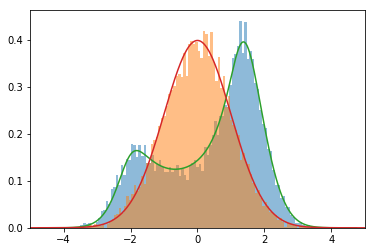

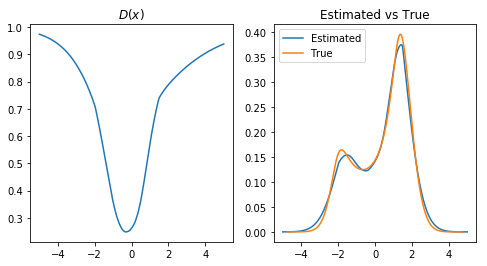

<Figure size 432x288 with 0 Axes>

In [9]:
if __name__ == "__main__":
  
  question3()
  question4()